In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors

# Load CSV files into DataFrames
df1 = pd.read_csv('C:/Users/user/Desktop/MGAS/Cleaned datasets/customer_locations.csv')
df2 = pd.read_csv('C:/Users/user/Desktop/MGAS/Cleaned datasets/potential_service_areas.csv')

# Convert DataFrames to GeoDataFrames
gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.longitude, df1.latitude))
gdf2 = gpd.GeoDataFrame(df2, geometry=gpd.points_from_xy(df2.longitude, df2.latitude))

# Set a common CRS
gdf1.crs = 'EPSG:4326'  # WGS84
gdf2.crs = 'EPSG:4326'

# Perform Nearest Neighbor join
nn = NearestNeighbors(n_neighbors=1, metric='haversine')
nn.fit(gdf2[['longitude', 'latitude']])

distances, indices = nn.kneighbors(gdf1[['longitude', 'latitude']])

# Add nearest neighbor information to gdf1
gdf1['nearest_distance'] = distances
gdf1['nearest_index'] = indices

# Merge the two GeoDataFrames based on the nearest index
join_result = gdf1.merge(gdf2, left_on='nearest_index', right_index=True, suffixes=('_gdf1', '_gdf2'))

# Save the result as a new CSV file
join_result.to_csv('C:/Users/user/Desktop/MGAS/Duplicates/spatial_join_result.csv', index=False)


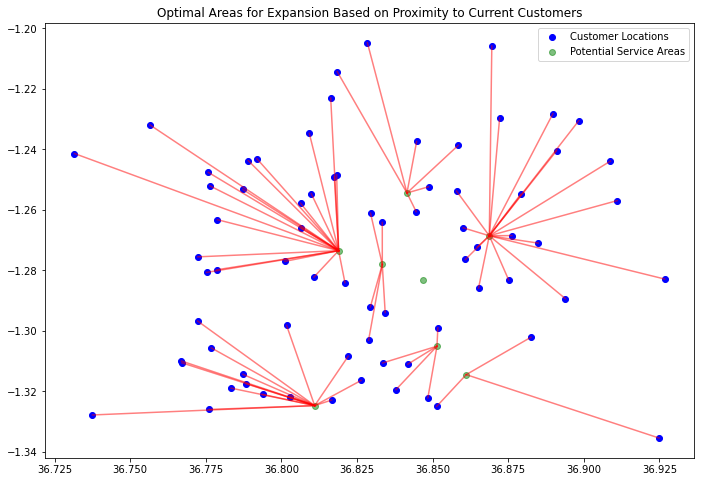

In [2]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot customer locations
gdf1.plot(ax=ax, color='blue', label='Customer Locations')

# Plot potential service areas
gdf2.plot(ax=ax, color='green', alpha=0.5, label='Potential Service Areas')

# Plot the nearest service areas for each customer
for idx, row in join_result.iterrows():
    ax.plot([row['longitude_gdf1'], row['longitude_gdf2']], [row['latitude_gdf1'], row['latitude_gdf2']], color='red', alpha=0.5)

# Add legend and title
ax.legend()
ax.set_title('Optimal Areas for Expansion Based on Proximity to Current Customers')

# Show the plot
plt.show()


In [3]:
import folium

# Create a folium map centered at the mean latitude and longitude of the customer locations
center_lat = gdf1['latitude'].mean()
center_lon = gdf1['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add customer locations to the map
for idx, row in gdf1.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['customer_id']).add_to(m)

## Add potential service areas to the map
for idx, row in gdf2.iterrows():
    folium.CircleMarker([row['latitude'], row['longitude']], radius=5, color='green', fill=True, fill_color='green', fill_opacity=0.5, popup=f"Area {idx}").add_to(m)


# Add lines indicating the nearest service areas for each customer
for idx, row in join_result.iterrows():
    folium.PolyLine([[row['latitude_gdf1'], row['longitude_gdf1']], [row['latitude_gdf2'], row['longitude_gdf2']]], color='red', weight=2.5, opacity=0.5).add_to(m)

# Save the map as an HTML file
m.save('C:/Users/user/Desktop/MGAS/MAPS/map.html')

# Display the map
m
